In [1]:
import scipy
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data Assimilation

### "Getting our Data Ducks in a Row"

In the most general terms, data assimilation techniques attempt to combine theoretical models with observations (or really any two datasets) in the "best way possible" to improve both sets of data. This amounts to rectifying errors in both the forecast (magnitude, location and timing of event) and the necessarily sparse observations of the true system state: "for large scale systems, it is almost impossible to experimentally measure the full state of the system at a given time. For example, imagine simulating the atmospheric or oceanic flow, then you need to measure the velocity, temperature, density, etc. at every location corresponding to your numerical grid," (Ahmed+2020).

Data assimilation proceeds sequentially in time, applying a correction to the forecast based on a set of observed data and estimated errors that are present in both the observations and the forecast itself. The model organizes and propagates forward the information from previous observations. As new observations are added, that data is used to modify the model state to be as consistent as possible with them (i.e., data) *and* the previous information --> a sort of ouroboros of analysis and forecast.

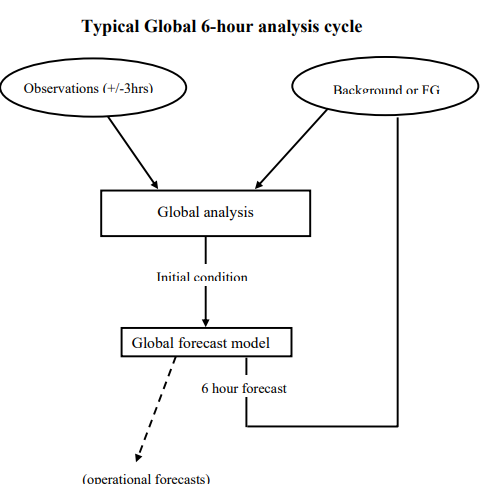


The very first step of the data assimilation cycle (which we don't see as it happens pre-blend) is the production of something like URMA -- taking irregularly spaced observations (both direct and indirect) of atmospheric state variables and estimating them onto a regular grid. Once gridded, these can be modified by the background field. And then applied to numerical models as a supplement for the ICs. 

As mentioned above, data assimilation amounts to a pre-process for NWPs but can also be used to combine predictions from several models + corrections from contemporaneous observations == the blend! BUT - correcting for the errors in the forecasts associated with both position and amplitude is difficult; "the standard measures of forecast skill, such as root-meansquare (r.m.s.) error and anomaly correlation all measure forecast error as the difference between a forecast and ananalysis at the same point in space and time. They are incapable of identifying a phase error as such. For example, a forecast of an intense, fast-moving feature can have a low skill score because of a small phase error that a human forecaster may consider minor. Hence, there is a need for an objective skill evaluation method that accounts for the presence of both phase and amplitude errors" (Nehrkorn+2003). 

Related is the treatment of probabilistic forecasts generated from ensembles of perturbed models. In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events as predicted by the model. Furthermore, while QM (theoretically) provides really great probabilitic predictions for weather events, it's difficult to know how to communicate more deterministic estimates from an ensemble. 

An improvement we hope to make to the blend is to somehow efficiently combine the physically meaningful information encoded in the entire distribution of predictions from the ensemble. One way to do that is via coalescence, which seeks to quantify the uncertainity for coherent structures that can suffer multiple types of error in an ensemble of forecasts (as in above, it is necessary to correct for both phase and amplitude errors). "Consider, as an illustration, an ensemble of “one dimensional” fronts that contain position and amplitude errors, as shown in (the Figure below). If we were to ask what the mean front is, clearly the simplest solution is to take the mean of these fields, that is, calculate the mean vector. That would be terribly wrong, of course, because the mean simply does not look like any front in the ensemble. Coalescence instead calculates the mean amplitude field by marginalizing relative position errors. The method invokes an “N-body” type solution where each member in the ensemble gravitates to the others. In so doing, all of them discover a mean position where the amplitude mean is meaningful," (Ravela+2012)

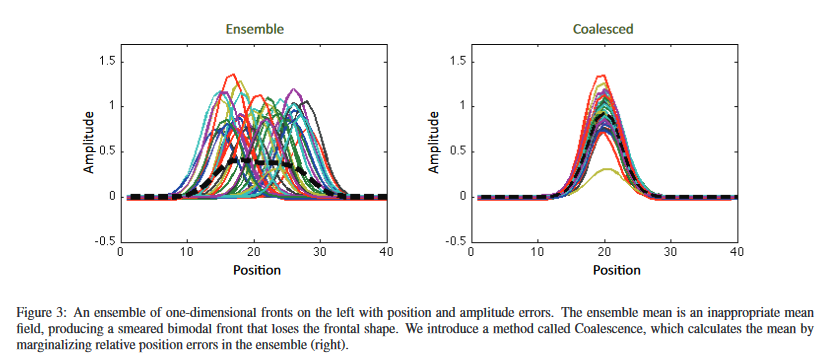

## Data Assimilation with 3DVAR

As a starting point in Ahmed+2020, we begin by defining a state vector **u** that evolves over time which describes all of the information about the actual state of (in our case) the atmosphere. The time evolution of the state is governed by a set of dynamical equations (which, unfortunately for us and is really the impetus of this entire process, are very very sensitive to the input initial conditions). **u$_t$** is then the vector of true values of the state. The background **u$_b$** contains prior information about the state of the system currently. Of course, we cannot observe all of the aspects of the system so the collection of information we actually know about the system at a specific time is **w**(t). In fact, we usually cannot directly observe most of the physical quantities of the state (e.g., temperature, humidity) and instead observe them indirectly via radar measurements. In light of this, **w** is related to **u$_t$** via a mapping *h* (observation operator) between state space and measurement space (plus some measurement noise/errors.)

The objective of DA is to combine our prior knowledge of the system state (**u$_b$**) and observations (**w**) to approximate the true state of the system (**u$_t$**). This approximation is the analysis **u$_a$**. 

To demonstrate how this works, we'll use an example dynamic system (called Lorenz 63) that has been well tested. We'll walk through the 3D variational DA method (though not an exhaustive derivation) and how we can optimize the analysis from simple assumptions about the background and measurement errors.

In [78]:
def Lorenz63(state,sigma,beta,rho):
    x, y, z = state #Unpack the state vector
    f = np.zeros(3)
    f[0] = sigma * (y - x) #dx/dt
    f[1] = x * (rho - z) - y #dy/dt
    f[2] = x * y - beta * z #dz/dt
    return f 

#and to compute time derivatives, use Runge-Kutta method
def Runge_Kutta(eq,state,dt,*args):
    
    k1 = eq(state,*args)
    k2 = eq(state+k1*dt/2,*args)
    k3 = eq(state+k2*dt/2,*args)
    k4 = eq(state+k3*dt,*args)

    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

Under 3DVAR, we aim to optimize the cost function *J*(**u**) in order to find **u$_a$**:

$$ \textit{J}(\textbf{u}) = {1 \over 2} {(\textbf{w} - \textit{h}(\textbf{u}))^{\textit{T}} \textbf{R}^{-1}(\textbf{w} - \textit{h}(\textbf{u}))} + {1 \over 2} {(\textbf{u} - \textbf{u}_b)^{\textit{T}} \textbf{R}^{-1}(\textbf{u} - \textbf{u}_b)} $$


where **R** is the covariance matrix of the observations (minus the observation operator) and **B** is the covariance matrix of the background. We optimize *J*(**u**) by taking the gradient and setting to zero. After some (gross) matrix operations and assuming linearity, we arrive at a solution for **u$_a$**:

$$ \textbf{u}_a = {\textbf{u}_b + \textbf{B}\textbf{H}^{\textit{T}}} (\textbf{R} + \textbf{H} \textbf{B} \textbf{H}^{\textit{T}})^{-1} (\textbf{w} - \textbf{H}\textbf{u}_b) $$

where **H** = **D**(**u**) (Jacobian matrix of *h*) for a linear observation operator *h*(**u**) = **Hu**. Ahmed+2020 describe this solution as the observation-space solution. **u$_a$** can also be solved in model-space with some re-arranging. This can be helpful if, e.g., there are less parameters in model-space vs. observation-space (since that would impact the dimension of the various matrices).

In [3]:
def ua_3DVAR(ub,w,H,R,B,opt):
    A = R + H@B@(H.T) #R + HBH^T
    b = (w-H@ub) #w-Hu_b
    ua = ub + B@(H.T)@np.linalg.solve(A,b) 
        
    return ua

In [37]:
#set up our test case

#Lorenze params
sigma=10.
beta=8./3.
rho=28.

#time evo
dt=0.01
end_t = 10.
t = np.arange(0,end_t+dt, dt)

ut_t0 = np.array([1,1,1]) # True initial conditions
ut = np.zeros([3,1000+1]) #true x,y,z, evolving for t=1000 units but need to add one for IC slot
ut[:,0] = ut_t0
for k in range(1,len(t)):
    ut[:,k] = Runge_Kutta(Lorenz63,ut[:,k-1],dt,sigma,beta,rho)

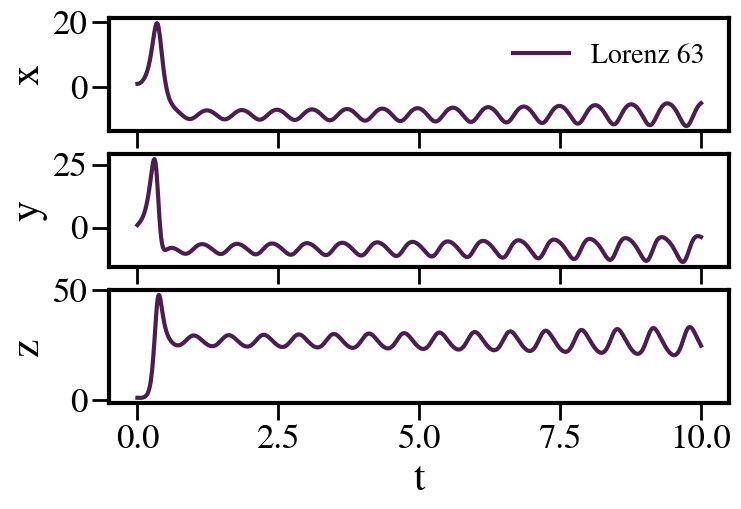

In [30]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,5))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])


axes[2].set_xlabel('t')
axes[0].legend(frameon=False)

In [51]:
## sample observations. let's assume we only observe the first 2 seconds of evolution at every 0.2s
dt_m = 0.2 #time period between observations
tm_m = 2 #maximum time for observations
nt_m = int(tm_m/dt_m) #number of observation instants

ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)
t_m = t[ind_m]

#BUT we also need to consider our measurement errors / observation operator
#for this example, we'll just assume a 1:1 mapping between observation and system state; i.e., h(u) = u so H is just the identity matrix
H = np.eye(3)

#measurements are assumed to have Gaussian noise with mu=0 and sigma = 0.15 (for all components)
sig_m= 0.15  # standard deviation for measurement noise
R = sig_m**2*np.eye(3) #covariance matrix for measurement noise

num_obs=0
w = np.zeros([3,nt_m]) #measurement

while num_obs < nt_m:
    for obs_time in t_m:
        obs = ut[:,np.where(t == obs_time)[0][0]]
        w[:,num_obs] = H@obs + np.random.normal(0,sig_m,[3,])
        num_obs +=1


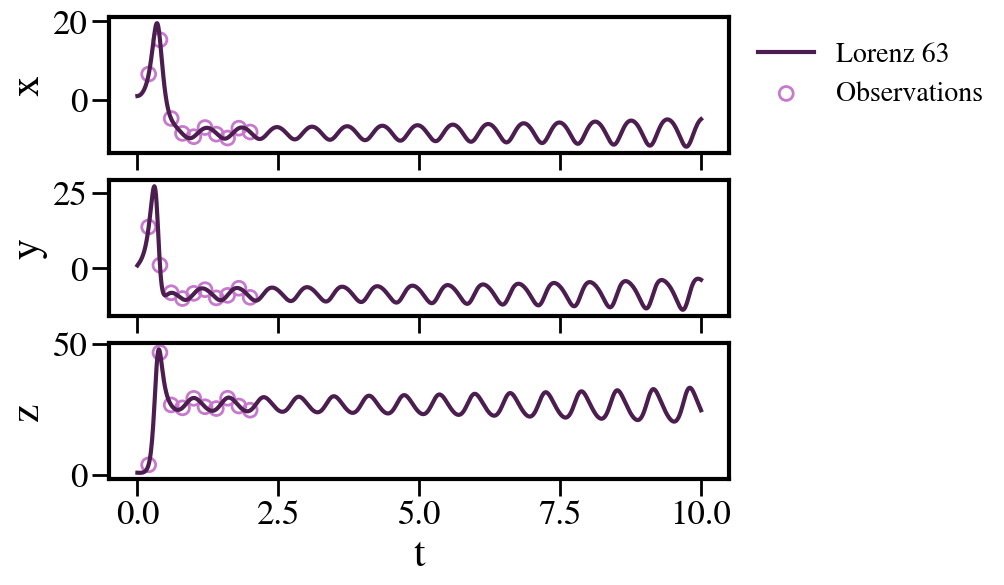

In [74]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])

    axes[i].scatter(t_m, w[i], marker='o', facecolor='None', lw=2,s=100, edgecolor='#C77ACD', label='Observations')


axes[2].set_xlabel('t')
axes[0].legend(frameon=False, bbox_to_anchor=(1.45,1))

In [79]:
#now for data assimilation

ub_t0 = np.array([2.0,3.0,4.0]) #initial condition for the background
#assume background covariance with sigma = 0.1
sig_b= 0.1 
B = sig_b**2*np.eye(3)


ub = np.zeros([3,len(t)])
ub[:,0] = ub_t0

#analysis, initialize at background
ua = np.zeros([3,len(t)])
ua[:,0] = ub_t0

km = 0
for k in range(nt):
    ub[:,k+1] = Runge_Kutta(Lorenz63,ub[:,k],dt,sigma,beta,rho)
    ua[:,k+1] = Runge_Kutta(Lorenz63,ua[:,k],dt,sigma,beta,rho)

    if (km<nt_m) and (k+1==ind_m[km]): #replace background with observations if available
        ua[:,k+1] = ua_3DVAR(ua[:,k+1],w[:,km],H,R,B,3)  
        km = km+1

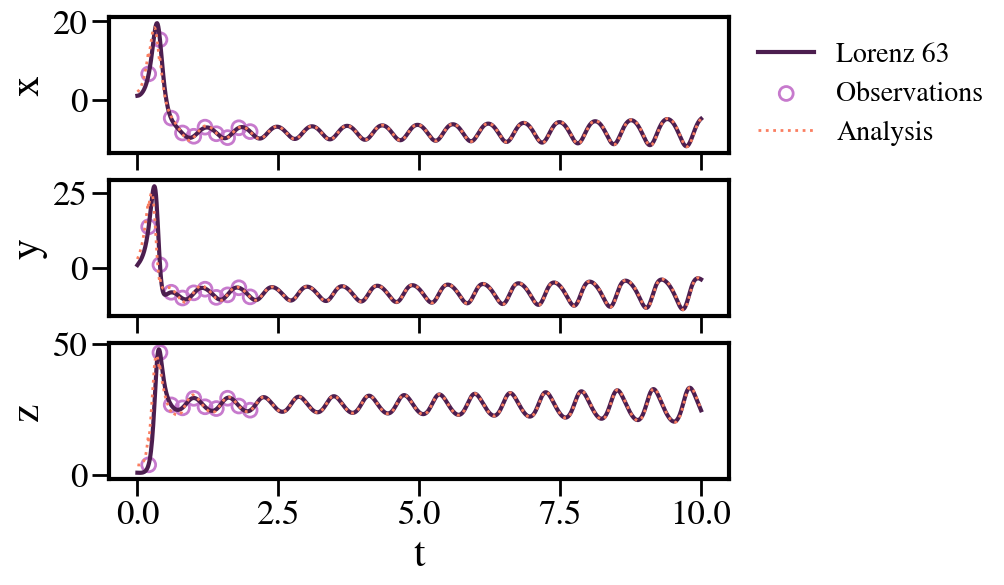

In [80]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])

    axes[i].scatter(t_m, w[i], marker='o', facecolor='None', lw=2,s=100, edgecolor='#C77ACD', label='Observations')
    axes[i].plot(t, ua[i], color='#FA7E61', lw=2,ls=':', label='Analysis')


axes[2].set_xlabel('t')
axes[0].legend(frameon=False, bbox_to_anchor=(1.45,1))

An interesting question is what happens if our guess for the initial background is bad? Since the analysis is heavily influenced by the evolution of the background, this could potentially disrupt the entire thing.

In [97]:
ub_t0 = np.array([7.,7.,7.]) #initial condition for the poorly estimated background

ub = np.zeros([3,len(t)])
ub[:,0] = ub_t0

ua = np.zeros([3,len(t)])
ua[:,0] = ub_t0

km = 0
for k in range(nt):
    ub[:,k+1] = Runge_Kutta(Lorenz63,ub[:,k],dt,sigma,beta,rho)
    ua[:,k+1] = Runge_Kutta(Lorenz63,ua[:,k],dt,sigma,beta,rho)

    if (km<nt_m) and (k+1==ind_m[km]): #replace background with observations if available
        ua[:,k+1] = ua_3DVAR(ua[:,k+1],w[:,km],H,R,B,3)  
        km = km+1

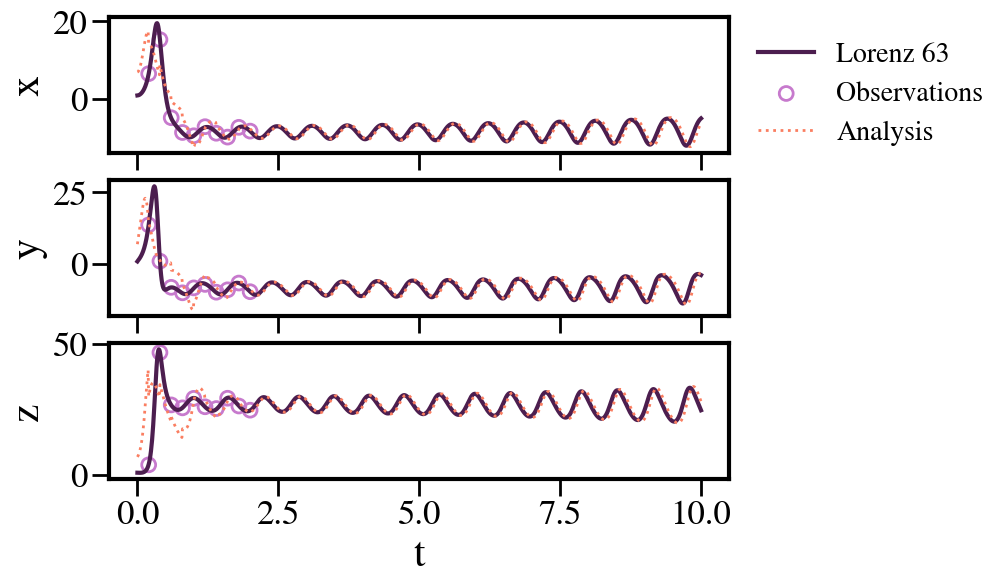

In [98]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])

    axes[i].scatter(t_m, w[i], marker='o', facecolor='None', lw=2,s=100, edgecolor='#C77ACD', label='Observations')
    axes[i].plot(t, ua[i], color='#FA7E61', lw=2,ls=':', label='Analysis')


axes[2].set_xlabel('t')
axes[0].legend(frameon=False, bbox_to_anchor=(1.45,1))

You can see the wheels start to come off a bit. We still get the periodic nature of the system down and are at least aided in the beginning by the observations, but there's a lot of error between the true state and the analysis. This is the case lots of times in forecasting! A model of storm system or front can be displaced from the actual system by quite a lot; even though the model predicts the prescence of the storm, it can struggle to get both the location/timing and amplitude correct. How can we tackle that? And how do we evaluate a model's goodness/badness in these cases? And what if we have an ensemble of models?

## Correcting both position and amplitude errors

The last demo we did above and the first in Ravela+2006 (shown below) show that typical data assimilation techniques like 3DVAR that consider only amplitude errors are unfit for scenarios where the forecast suffers from relatively large positional uncertainties.

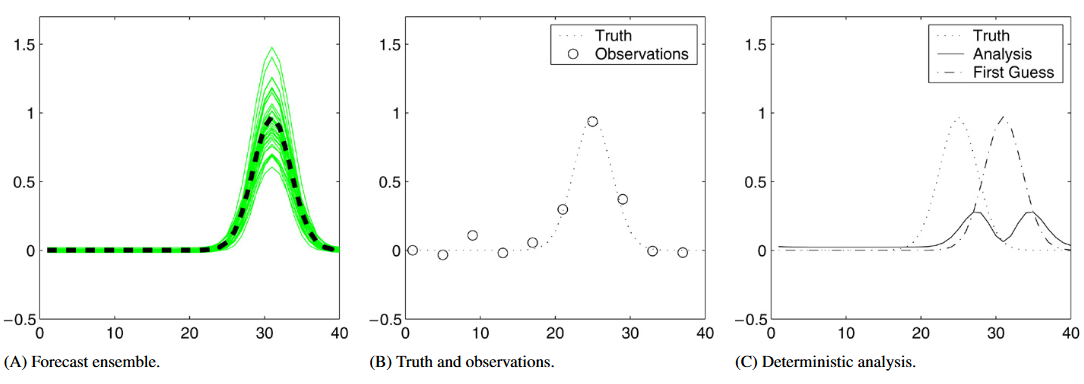

In the second example from Ravela, the ensemble again has position and amplitude errors but each member has a unique position offset.

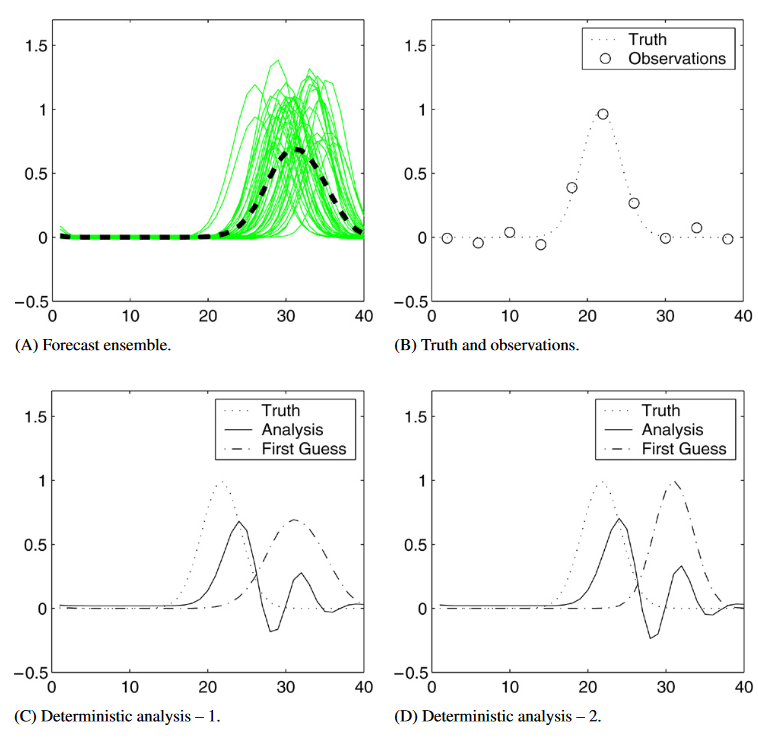

"The analysis from the procedure just discussed is shown. It is clear that the analysis (solid line) looks like neither the forecast ensemble nor the truth. It’s somewhere in between, being pulled by the observations in some places and the background at others. It has replaced a single front with a bimodal front of far weaker strength," (Ravela+2006).


"To address the position error problem, we reformulate the classical quadratic objective in a way that allows position adjustments in addition to amplitude adjustments. The key step in this new approach is to explicitly represent and **minimize position errors**. Therefore, we introduce auxiliary control variables (**displacements**) that are estimated along with amplitudes. The displacement variables are defined at each node of the grid representing the state and specify a deformation of the grid," (Ravela+2006)

# Correcting Position and Amplitude Errors for NBM with Coalescence (Nehrkorn, Hamill, and Henderson, in prep.)

The corrrection and transformation of the distribution of forecasted features to deterministic products is nontrivial: "the raw ensemble mean is generally better than any single ensemble member in terms of mean squared errors, but predicted precipitation features are often unrealistic; because of differences in the position of precipitation features in the individual ensemble members, the ensemble mean areal extent is generally too large and the forecast extrema are too small. In addition, the ensemble mean product lacks fine-scale detail."

In the NBM, amplitude/additive corrections are made with the quantile mapping technique (see [the notebook on QMD in the Blend](https://github.com/SidneyLower-NOAA/mdl_smd_grib2io/blob/main/statistical_surveyor_of_sorts.ipynb)) but as of yet there is not a robust way to correct for position errors; the technique described in Nehrkorn, Hamill, and Henderson -- based on work by Nehrkorn, Auligne, and Hoffman 2014, Hoffman & Grassotti 1996, and Hoffman+1999 -- attempts to combine QM with coalescence in order to combine the information from the entire ensemble distribution (mindful of distribution variances which carry meaning).

## Feature Alignment Technique

Hoffman & Grassotti 1996 and Hoffman+1999, mentioned above, introduce a method for aligning forecast and observational data later called *Feature Calibration and Alignment* (FCA) by optimizing a set of vectors describing the spatial displacement and amplitude residuals between the two datasets. The alignment step is sometimes called *Feature Alignment Technique* (FAT) and can be used to align forecasts with observations or, like in coalescence, align ensemble members to arrive at a more physically meaningful ensemble mean. Below, I describe the feature alignment technique as outlined in Nehrkorn, Hamill, and Henderson (in prep) that aims to correct position errors between ensemble members before using QMD to correct amplitude errors between the ensemble and the analysis.

Determining a two-dimensional field of displacement vectors ($\delta$ **i**, $\delta$ **j**) that results in an improved agreement of a forecast **x** with available observations **y** is formulated as a nonlinear optimization of an objective function:

$$ J = J_r(\textbf{y}, H(\textbf{x}), \delta \textbf{i}, \delta \textbf{j}) + J_p (\delta \textbf{i}, \delta \textbf{j}) $$

where $J_r$ measures the residual errors of the adjusted field, $J_p$ is a penalty function that combines various constraints of the displacements, and $H$ is the observation operator that transform the forecast to observed variables. The displacements themselves are represented by a truncated double consine series, including only terms with a total wavenumber not exceeding some truncation wavenumber.

The residual error is calculated via 

$$ J_r = \sum_{n=1}^N {(y_n(i_n, j_n) - \textbf{x}(i_n + \delta \textbf{i}, j_n + \delta \textbf{j}))^2 \over \sigma_n^2} $$

over N observations. Importantly, FAT is versatile in that $y_n$ can be an analysis/observational dataset *or* something like the ensemble mean like in coalescence. The residual error just simply measures the mismatch between two datasets at the same location and time. 

The full penalty function is found by summing over the (weighted) individual penality functions that each constrain the displacements in a certain way:

$$ J_p = \lambda_a J_a + \lambda_d J_d + \lambda_m J_m + \lambda_{div} J_{div} $$

"The barrier function $J_a$, which is evaluated in gridpoint space, is designed such that displacements larger than a typical displacement scale Si are penalized heavily. In the smoothness constraint $J_d$, evaluated in spectral space as described in Hoffman and Grassotti (1996), roughness is measured by the mean square Laplacian of the scaled displacements, which penalizes higher wavenumbers selectively. The magnitude constraint $J_m$, evaluated in spectral space, measures the mean square magnitude of the displacements, which penalizes all wavenumbers equally, and serves to suppress displacements in data-void areas. Finally, the divergence constraint $J_{div}$, evaluated in gridpoint space, limits the amount of divergence in the displacement field."

The weights and free parameters that define each $J_p$ have been tuned from experiments comparing coalescned mean fields and selected ensemble member displacements.

### 1D Experiment: Aligning an Ensemble of Gaussian "Fronts"

As a simple demo, I will take the example ensemble from Ravela+2006 and align each member to the position of the ensemble mean, thereby arriving at a more physically meaningful mean front than that calculated from the un-aligned fronts.

In [10]:
def generate_ensemble_front(p,n=1,p0=20.,sigma0=2.):
    this_ens=[]
    xf_med = np.exp((-(p-p0).T * (p-p0))/(2*sigma0**2))
    for mem in range(n):
        a = np.random.normal(1,0.2,1)
        b = np.random.normal(0,0.01,1)
        p0 = np.random.normal(20, 3, 1)
        xf = np.exp((-(p-p0).T * (p-p0))/(2*sigma0**2))

        this_ens.append(xf)

    return this_ens
    

In [16]:
nodes = np.linspace(0,40,40)

In [17]:
fronts = generate_ensemble_front(nodes,n=40)

Text(0, 0.5, 'amplitude')

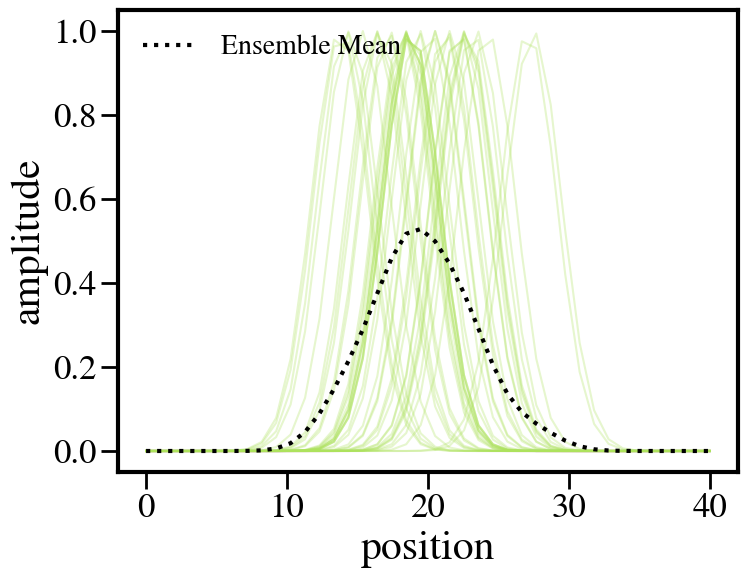

In [18]:
for i in range(40):
    plt.plot(nodes, fronts[i], color='#ADE25D', alpha=0.3)
plt.plot(nodes, np.mean(fronts, axis=0), color='black', ls=':', lw=3, label='Ensemble Mean')
plt.legend(frameon=False, loc='upper left')
plt.xlabel('position')
plt.ylabel('amplitude')

For a further simplification, I will define the cost function from just the residual error ($J_r$) and the barrier penalty ($J_a$) from above.

In [20]:
def residual_errors(delta, ens_data, ens_mean, ens_std, old_vec):

    #get ensemble at displaced grid points
    displaced_ens = np.interp(old_vec+delta, old_vec, ens_data)
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / ens_std**2)

In [21]:
def displacement_penalty(disp_vec,S):
    return np.sum((disp_vec / S)**20)

In [22]:
def get_j(delta, ens_data, ens_mean, ens_std, S, old_vec):
    
    j_r = residual_errors(delta, ens_data, ens_mean, ens_std, old_vec)
    j_a = displacement_penalty(delta, S)

    return j_r + j_a
    

In [43]:
ens_std = np.std(fronts)
ens_mean = np.mean(fronts, axis=0)
S = 4.
delta0 = 1.

In [44]:
ens_displacement=[]
for i in range(40):
    minimize = scipy.optimize.minimize(get_j, delta0, args=(fronts[i], ens_mean, ens_std, S, nodes), 
                               method='BFGS')
    ens_displacement.append(minimize.x)

In [57]:
def remap_front(front, displaced_vec, remap_nodes):
    displaced_ens = np.interp(remap_nodes, displaced_vec, front)
    return displaced_ens
    

In [61]:
mean_coalesced_front = []
displaced_fronts = []
for i in range(40):
    displaced_fronts.append(remap_fronts(fronts[i], nodes - ens_displacement[i], nodes))
for i in range(40):
    mean_coalesced_front.append(np.mean([item[i] for item in displaced_fronts]))

Text(0, 0.5, 'amplitude')

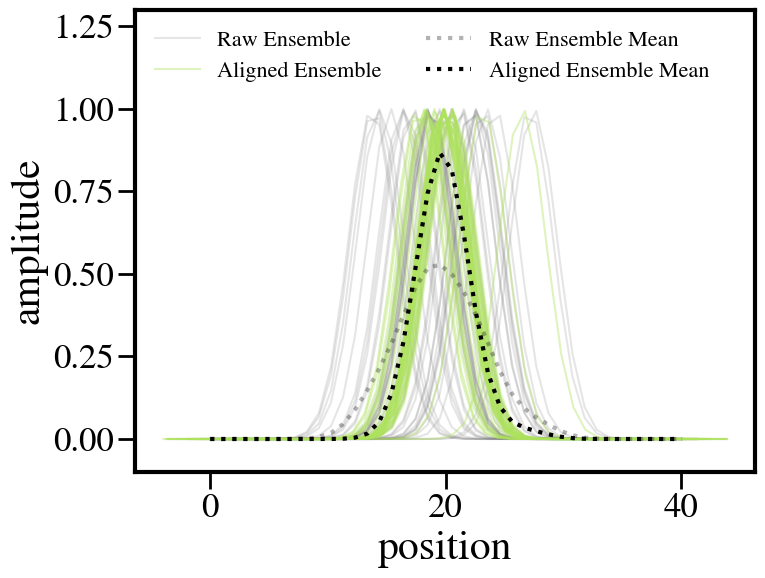

In [71]:
for i in range(40):
    if i == 1:
        plt.plot(nodes, fronts[i], color='gray', alpha=0.2, label='Raw Ensemble')
    else:
        plt.plot(nodes, fronts[i], color='gray', alpha=0.2)

for i in range(40):
    if i == 1:
        plt.plot(nodes - ens_displacement[i], fronts[i], color='#ADE25D', alpha=0.4, label='Aligned Ensemble')
    else:
        plt.plot(nodes - ens_displacement[i], fronts[i], color='#ADE25D', alpha=0.4)

plt.plot(nodes, np.mean(fronts, axis=0), color='black', ls=':', lw=3,alpha=0.3, label='Raw Ensemble Mean')
plt.plot(nodes, mean_coalesced_front,color='black', ls=':', lw=3,label='Aligned Ensemble Mean')
plt.legend(frameon=False, loc='upper left',ncol=2, fontsize=16)
plt.ylim([-0.1, 1.3])
plt.xlabel('position')
plt.ylabel('amplitude')

### 2D: FAT on GEFS Precipitation Forecasts

So how to apply to the NBM? Generalizing to 2D is not so hard in princple, but we need to be careful about managing computation costs: GEFS alone has 21 members with ~260,000 grid points which can be unruly to try and calculate displacement vectors for (even just horizonally). If alignment must be done on a finer grid (in anticipation of QMD calulcations with respect to URMA) the situation worsens. But for demonstration purposes, I have cut down the problem by only dealing with a slice of GEFS data (roughly encompassing CONUS but still just at native GEFS resolution).

In [ ]:
###     A Brief Aside to Download GEFS Data from AWS 
# /scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/get_gefs_data.py
#g = grib2io.open('/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/gefs19.t12z.f006')

In [2]:
#get GEFS members

adam_dat_dir = '/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/'
gefs_paths = sorted(glob(adam_dat_dir+'gefs*.t12z.f006'))
filters = dict(productDefinitionTemplateNumber=11)
gefs_data = xr.open_mfdataset(gefs_paths, chunks=None,engine='grib2io', filters=filters, parallel=False, concat_dim=[pd.Index(np.arange(len(gefs_paths)), name="member")],combine="nested")


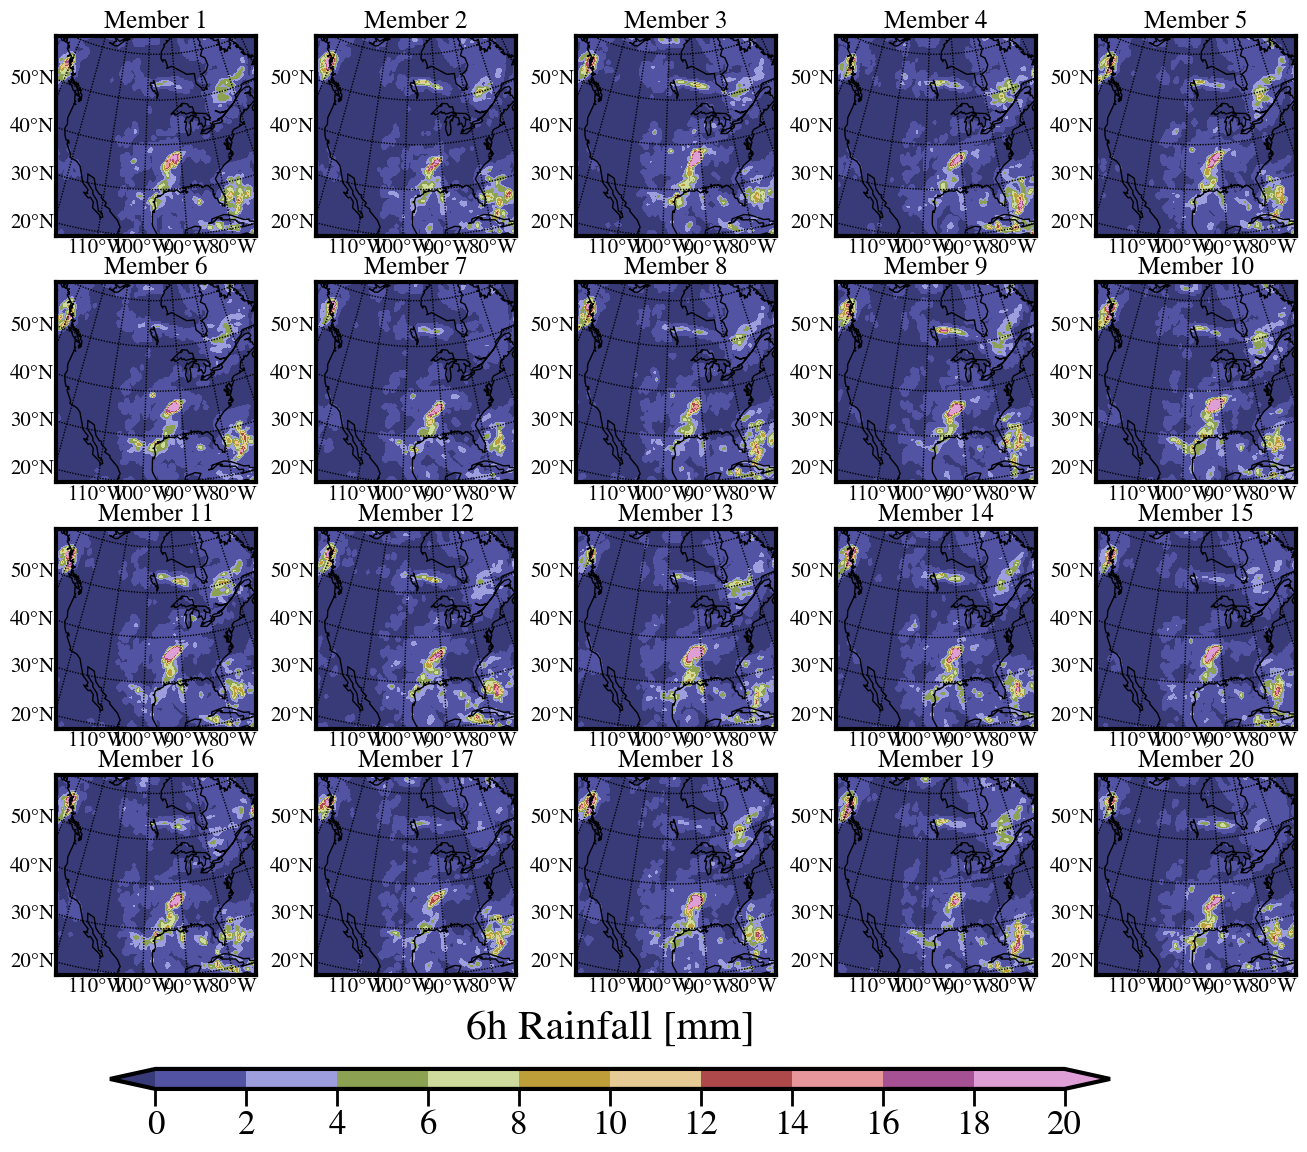

In [55]:
fig, axes = plt.subplots(4,5, figsize=(16,16))
temp_range = ticks=np.arange(0,22,2)
plt.subplots_adjust(wspace=0.3, hspace=-0.5)
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats

for i in range(4):
    for j in range(5):
        mem = 5*i + j
        gefs_pcp = gefs_data.APCP.data[mem]
        cs = m.contourf(xx,yy,gefs_pcp,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[i,j])
        m.drawcoastlines(ax=axes[i,j])
        m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=15,ax=axes[i,j])
        m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=15,ax=axes[i,j])
        axes[i,j].set_title(f'Member {mem+1}', fontsize=18)

cbar_ax = inset_axes(axes[3,0],
                    width="500%",  # width = 50% of parent_bbox width
                    height="10%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.2, -1.4, 1, 1),bbox_transform=axes[3,0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)


For starters, we will need to generalize the residual function defined above to be able to interpolate on a 2D grid. scipy's Regular Grid Interpolator is able to interpolate data on a regular, rectilinear grid onto a set of points (that aren't necessarily a regular grid but for our purposes are). The idea is to construct the GEFS GRIB2 grid, input that into RegularGridInterpolator, then distort the grid and re-evaluate the precipitation on that distorted grid, represented by a list of points.

That step will take place only in the residual cost function $J_r$. The other components of the objective function deal with constraints on the displacements, as described above, penalizing large distortions ($J_a$) and ensuring the resulting distorted field is smooth ($J_d$). 

In [4]:
from scipy.interpolate import RegularGridInterpolator

#objective function
def get_j(ck_arr, b_ik, mean, obs_error, S,interp_object,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    j_r = residual_error(c_k, b_ik, mean, obs_error, interp_object,grid_points)
    j_a = barrier_func_gp(c_k, b_ik, S)
    j_d = smoothness_func_spec(c_k, m_k, n_k)
    j_div = divergence_func_gp(c_k, b_ik)

    return j_r + j_a + j_d + j_div

def residual_error(c_k,b_ik,ens_mean, obs_error, interp_object,grid_points):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    
    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp_object(displaced_grid)

    displaced_ens = np.ones_like(ens_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[i,j] = displaced_precip[point]
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / obs_error**2)

def barrier_func_gp(c_k, b_ik,S): #Ja
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    return np.sum(((c_xi / S) +  (c_yi / S))** (20))

def smoothness_func_spec(c_k, m_k, n_k): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)
    scale = 0.5
    weight = 2.
    w_k={'x': (weight / scale**2) * nu_k,
            'y': (weight / scale**2) * nu_k}
    return np.sum(w_k['x'] * c_k['x']**2 + w_k['y'] * c_k['y']**2)

In [5]:
def divergence(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

def divergence_func_gp(c_k, b_ik):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    nx, ny = len(c_xi), len(c_yi)

    dx = divergence(c_xi)
    dy = divergence(c_yi)
    return (dx+dy)**2
    

One improvement (?) from the first example in 1D is the treatment / form the displacements take. In the first example, the displacements were physical -- we were finding the best set of displacements by evaluating the fit in grid space alone. Moving to 2D with more complicated coherent structures necessitates a more sophisticated handling of the displacements. In Nehrkorn, Hamill, and Henderson (in prep), following Hoffman & Grassotti 1996, the displacements are represented by a truncated double consine series, and we are searching for the optimal coefficients for those basis functions:


$$ B_{k} = 2 \sin (m_k (ax + \frac{\pi}{2})) \sin(n_k (ay + \frac{\pi}{2}))$$

where $m_k$, $n_k$ are determined by the choice of truncation wavenumber and $k$ are the wavenumbers up to that truncation == degrees of freedom. 

The displacements are then coefficients to these basis functions ($\Delta x, \Delta y$), with the distorted grid locations in physical/grid space found via

$$ x' = x + B\Delta x$$
$$ y' = y + B\Delta y$$

Below includes functions to calculate the set of basis functions by transforming the physical grid locations into Fourier space.

In [6]:
def basis_functions(target_x, target_y, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    x = grid2fourier(target_x, xrange)
    y = grid2fourier(target_y, yrange)

    b_ik = np.zeros((len(x), len(m_k)))

    for k in range(len(m_k)):
        b_ik[:, k] = 2 * np.sin(m_k[k] * x) * np.sin(n_k[k] * y)

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    m_k = np.repeat(np.arange(1, n + 1), n)
    n_k = np.repeat(np.arange(1, n + 1), np.repeat(n, n))
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

In [7]:
#get data
mem=0
min_lon = 460 #this box spans roughly 20-90 deg N and 130-60 deg W
max_lon = 600
min_lat = 0
max_lat = 140

conus_only = gefs_data.APCP.isel(y=slice(min_lat,max_lat), x=slice(min_lon,max_lon))
ens_mean = conus_only.mean(dim='member')#conus_only.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_mem = conus_only.data[mem].compute()

#setup displacements
m_k, n_k = basis_truncation(5)
y = conus_only.latitude.data.compute().T[0]
x = conus_only.longitude.data[0].compute()
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]]
    )
d_o_f = len(m_k)
c_k = {"x": np.repeat(0.1, d_o_f), "y": np.repeat(0.1, d_o_f)}
#sigh need to change c_k to array structure (in 1D!!) or else scipy.minimize will get mad
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 

#physical displacements
c_xi = np.dot(b_ik, c_k['x'])
c_yi = np.dot(b_ik, c_k['y'])

#setup list of grid points
#xy_grid = np.meshgrid(x,y, indexing='ij')
#xy_list = np.reshape(xy_grid, (2, -1), order='C').T
xy_list = np.reshape([x,y],  (2,-1),order='C').T
interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)

So here, we construct a grid from the lats/lons of the (subsample of the) GEFS grid. The regular grid interpolator will construct that grid and associate it with the ensemble mean. The c_k vectors represent the coefficients of the basis functions that optimially align the ensemble member to the mean, which will be applied to the grid points (xy_list) later given to interpolate.

Text(0.5, 0, 'y grid location')

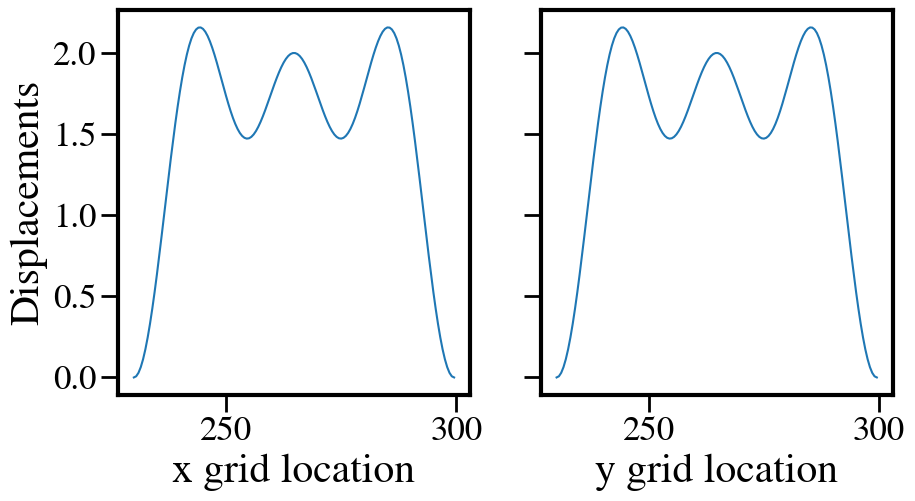

In [6]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

axes[0].plot(x, c_xi)
axes[1].plot(x, c_yi)
axes[0].set_ylabel('Displacements')
axes[0].set_xlabel('x grid location')
axes[1].set_xlabel('y grid location')

In [9]:
#minimize
std = 0.2
S=1.
print('minimizing')
start = datetime.datetime.now()
minimize = scipy.optimize.minimize(get_j,ck_arr , args=(b_ik, raw_mean, std, S,interp,xy_list, m_k, n_k), method='L-BFGS-B')
end = datetime.datetime.now()
print(end-start)

minimizing
0:00:16.517616


One thing I did not mention in the previous example is the method used to minimize the control variable. In Nehrkorn, Hamill, and Henderson (in prep.), the R source code used to optimize these displacements uses the nlminb function, an unconstrained and bounds-constrained quasi-Newton method optimizer based on a FORTRAN routine. In python, an equivalent method is scipy's L-BFGS-B, also a quasi-Newtonian bound-constrained minimization routine.

The output from minimizatioareis the displacement vect coefficientsor, which we can apply to the original conus-lite grid to arrive at the aligned precipitation field.

In [10]:
c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}

c_xi = np.dot(b_ik, c_k_minimized['x'])
c_yi = np.dot(b_ik, c_k_minimized['y'])
n_x_i = x + c_xi
n_y_i = y + c_yi

xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
displaced_precip = interp(displaced_grid)

displaced_ens = np.ones_like(raw_mean)
#print(np.shape(displaced_grid))
for i in range(len(c_xi)):
    for j in range(len(c_yi)):
        point = len(c_yi)*i+j
        #print(point)
        displaced_ens[i,j] = displaced_precip[point]

In [11]:
np.shape(displaced_precip)

(19600,)

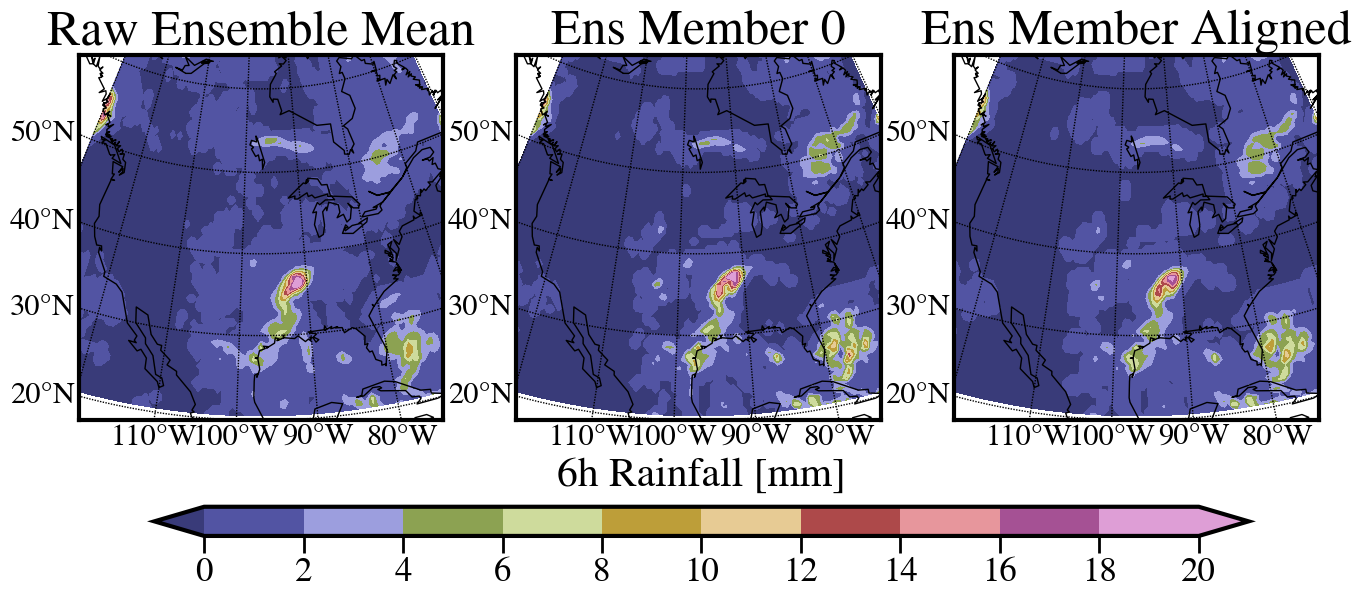

In [68]:
fig, axes = plt.subplots(1,3, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = conus_only.latitude.data, conus_only.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="300%",  # width = 50% of parent_bbox width
                    height="8%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.17, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)

axes[1].set_title(f'Ens Member {mem}')
cs = m.contourf(xx,yy,ens_mem,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)

axes[2].set_title(f'Ens Member Aligned')
cs = m.contourf(xx,yy,displaced_ens,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[2],)


for ax in range(3):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


In [69]:
#let's try all members
#get data
min_lon = 460 #this box spans roughly 20-90 deg N and 130-60 deg W
max_lon = 600
min_lat = 0
max_lat = 140

conus_only = gefs_data.APCP.isel(y=slice(min_lat,max_lat), x=slice(min_lon,max_lon))
ens_mean = conus_only.mean(dim='member')
raw_mean = ens_mean.data.compute()

#setup displacements
m_k, n_k = basis_truncation(5)
y = conus_only.latitude.data.compute().T[0]
x = conus_only.longitude.data[0].compute()
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)
xy_list = np.reshape([x,y],  (2,-1),order='C').T

full_ens_stitched = np.zeros_like(conus_only.data.compute())

for mem in tqdm(range(21)):
    ens_mem = conus_only.data[mem].compute()
    interp = RegularGridInterpolator((x,y), ens_mem,bounds_error=False, fill_value=None)
    c_k = {"x": np.repeat(0., d_o_f), "y": np.repeat(0., d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
    std = 0.2
    S=1.
    minimize = scipy.optimize.minimize(get_j,ck_arr , args=(b_ik, raw_mean, std, S,interp,xy_list, m_k, n_k), method='L-BFGS-B')

    c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}

    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp(displaced_grid)
    
    displaced_ens = np.ones_like(raw_mean)
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            #print(point)
            displaced_ens[i,j] = displaced_precip[point]
            
    full_ens_stitched[mem,:,:] = displaced_ens

  0%|          | 0/21 [00:00<?, ?it/s]

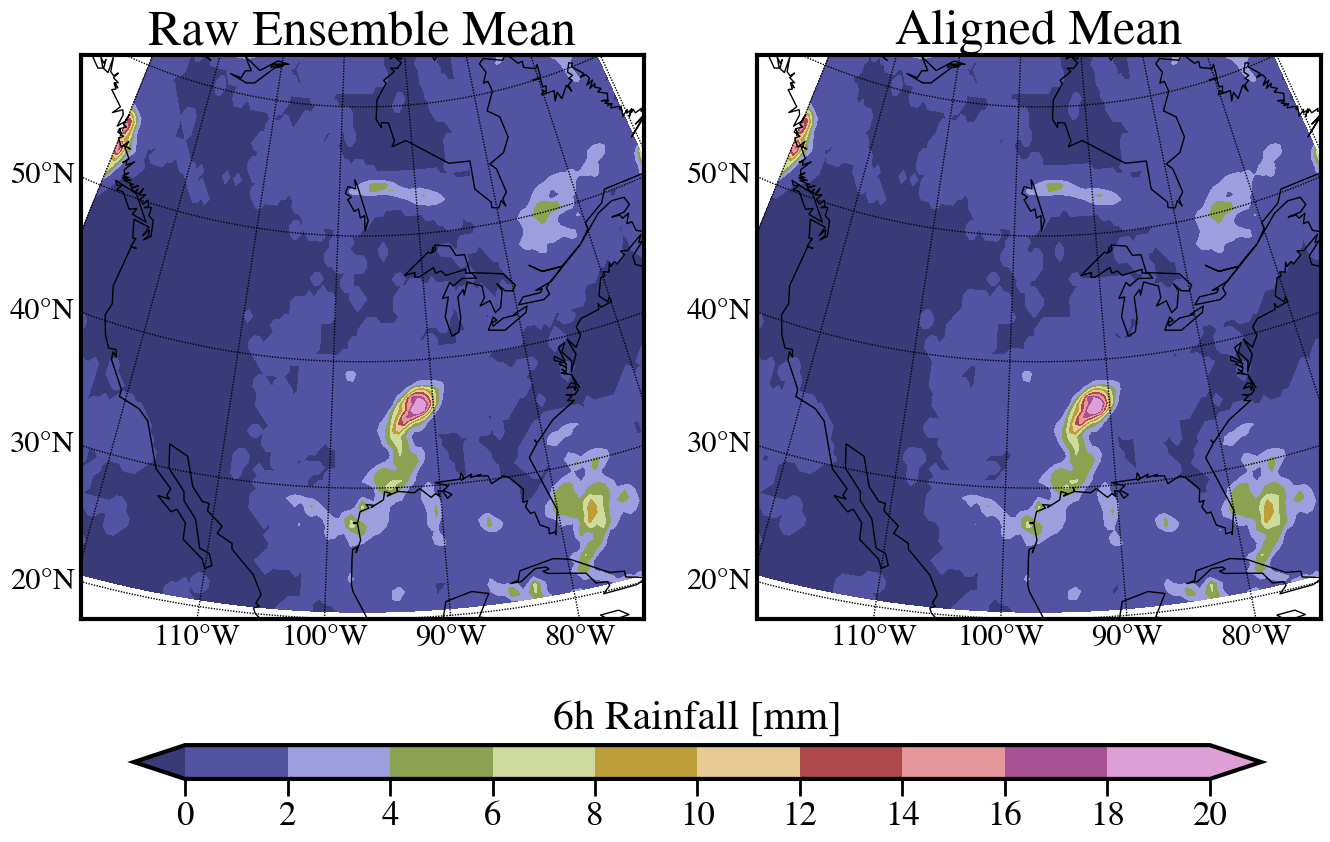

In [70]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = conus_only.latitude.data, conus_only.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='c')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="6%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)

axes[1].set_title(f'Aligned Mean')
cs = m.contourf(xx,yy,np.mean(full_ens_stitched, axis=0),levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)

for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


In [72]:
#save to zarr
members=np.arange(0,21)
aligned_ens_xr = xr.DataArray(full_ens_stitched, 
coords={'member': members,'longitude': conus_only.longitude,'latitude': conus_only.latitude,}, 
dims=["member","y", "x"],
                             attrs=gefs_data.APCP.attrs)

In [73]:
conus_only['aligned_APCP'] = aligned_ens_xr

In [74]:
conus_only.to_zarr('/scratch2/STI/mdl-sti/Sidney.Lower/coalescence_test.zarr')

## Now for something completely different: cross-correlation

In [30]:
# https://github.com/keflavich/image_registration/tree/master

Another technique that can be used for alignment between similar images of extended structures is cross correlation, which essentially measures the similarity between two objects;  high cross correlation between two images implies they are similar at that point. In astronomy (where I'm from!) this is commonly used to align single color images of the same object to get a composite image (e.g., an RGB image that combines red, blue, and green images together), accounting for mismatches between the images due to telescope movement. 

To apply this to forecasts, however, some things need to be considered. In the astronomy application, it is assumed (reasonably) that the mis-alignment between images can be corrected by a single shift, e.g., all pixels are translated by the same displacement. But this will typically not be the case when comparing forecasts to the ensemble mean or to an analysis. The misalignments there will be more complex and nonuniform across the grid. In that case, we can perhaps calculate the cross correlation between subsets of images, assuming that the shift needed to align an ensemble member to the mean is ~uniform locally. Below I use a package called [image_registration](https://image-registration.readthedocs.io/en/latest/) that is nominally for astronomical data but could be extended to forecast data. The code is based on [MATLAB routines](https://www.mathworks.com/matlabcentral/fileexchange/18401-efficient-subpixel-image-registration-by-cross-correlation) that uses FFT to compute the correlation.

In [50]:
from image_registration import chi2_shift, cross_correlation_shifts
from image_registration.fft_tools import shift
import image_registration

In [51]:
#get GEFS members

adam_dat_dir = '/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20210601/'
gefs_paths = sorted(glob(adam_dat_dir+'gefs*.t12z.f006'))
filters = dict(productDefinitionTemplateNumber=11)
gefs_data = xr.open_mfdataset(gefs_paths, chunks=None,engine='grib2io', filters=filters, parallel=False, concat_dim=[pd.Index(np.arange(len(gefs_paths)), name="member")],combine="nested")


In [52]:
### split into chunks, so offsets are ~local?
### calculate offsets and generate corrected image for each section, then stitch together with interpolation 

full_ens_stitched = np.zeros_like(gefs_data.APCP.data.compute())
ens_mean = gefs_data.APCP.mean(dim='member')#conus_only.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()

min_lon = 460
max_lon = 600
min_lat = 0
max_lat = 140

for mem in tqdm(range(21)):
    d_lat_lon = 5 #width/height of subset in units of latitude/longitude index
    #for 0.5 degree resolution == 2.5 degrees
    ens_mem = gefs_data.APCP.data[mem].compute()#conus_only.APCP.data[mem].compute()
    
    stitched_image = np.zeros_like(raw_mean)
    for lat_idx in range(min_lat,max_lat, d_lat_lon):
        for lon_idx in range(min_lon, max_lon, d_lat_lon):
            #print(f'...latitude = {lat_idx} : {lat_idx+d_lat_lon}')
            #print(f'...longitude = {lon_idx} : {lon_idx+d_lat_lon}')
            this_subset_mean = raw_mean[lat_idx:lat_idx+d_lat_lon, lon_idx:lon_idx+d_lat_lon]
            this_subset_mem = ens_mem[lat_idx:lat_idx+d_lat_lon, lon_idx:lon_idx+d_lat_lon]
            #print(np.shape(this_subset_mem))
            xoff, yoff, exoff, eyoff = chi2_shift(this_subset_mean, this_subset_mem, maxshift=5)
            corrected_image = shift.shiftnd(this_subset_mem, (-yoff, -xoff))
            #if (np.abs(xoff) > 5) or (np.abs(yoff) > 5):
            #    print(f'warning, large shift = {xoff, yoff} at ({mem}, {lat_idx}, {lon_idx})')
            stitched_image[lat_idx:lat_idx+d_lat_lon, lon_idx:lon_idx+d_lat_lon] = corrected_image
    full_ens_stitched[mem,:,:] = stitched_image

    
    



  0%|          | 0/21 [00:00<?, ?it/s]

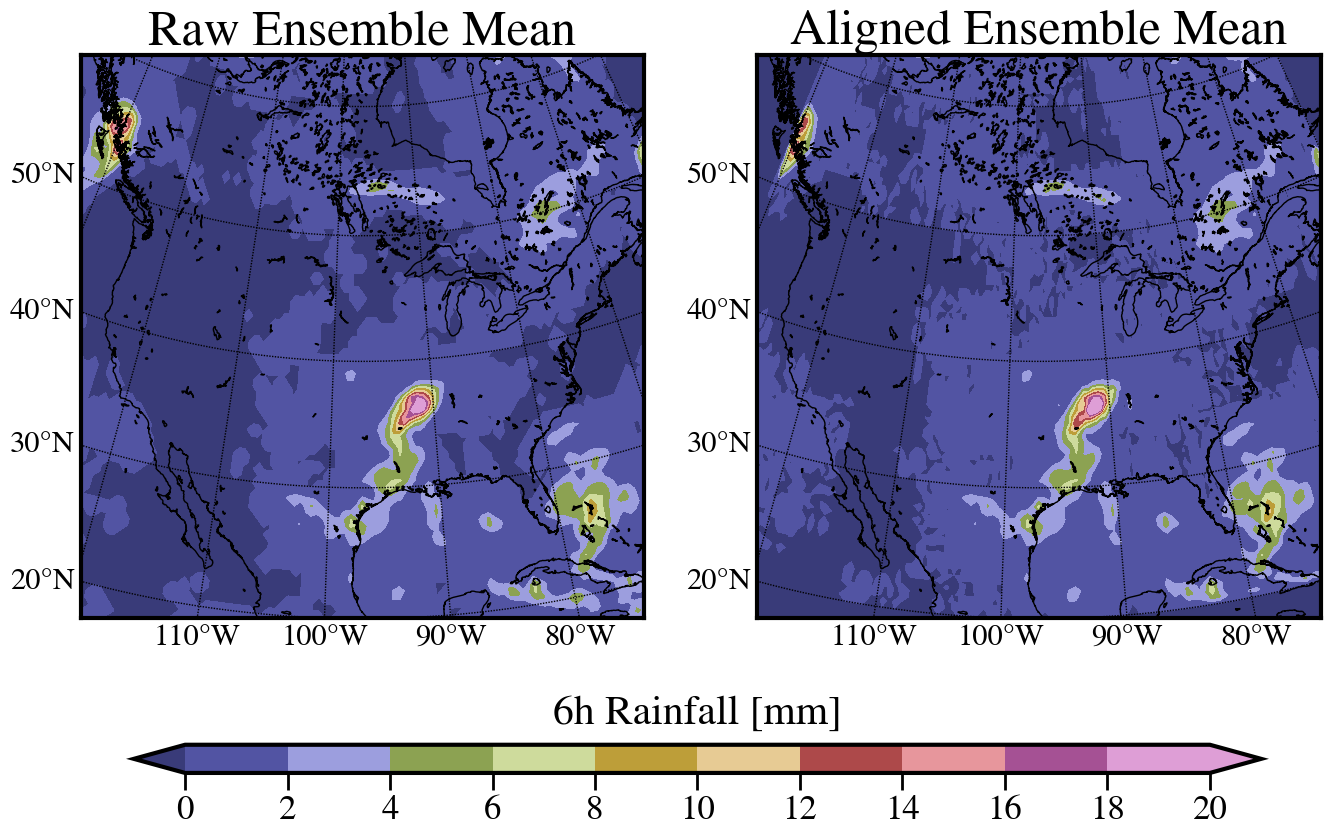

In [53]:
fig, axes = plt.subplots(1,2, figsize=(16,12), sharey=True)
temp_range = np.arange(0,22,2)

#GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=42,width=5e6,height=5e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
cs = m.contourf(xx,yy,raw_mean,levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[0])
axes[0].set_title('Raw Ensemble Mean')
cbar_ax = inset_axes(axes[0],
                    width="200%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='upper left',bbox_to_anchor=(0.07, -1.2, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs,orientation='horizontal', cax=cbar_ax,ticks=np.arange(0,22,2))
cbar.ax.set_xticklabels(['0','2','4', '6', '8', '10','12','14','16','18','20']) 
cbar.set_label('6h Rainfall [mm]', labelpad=-95)

axes[1].set_title(f'Aligned Ensemble Mean')
cs = m.contourf(xx,yy,np.mean(full_ens_stitched, axis=0),levels=temp_range,cmap=plt.cm.tab20b,extend='both',ax=axes[1],)



for ax in range(2):
    m.drawcoastlines(ax=axes[ax])
    m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes[ax])
    m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes[ax])


There are some noticeable differences between the aligned mean calculated with the coalescence routine and the one calculated from cross-correlation. Some of these can be attributed to the fact that the cross-correlation is calculated on lat-lon subsections of the GEFS forecast, leading to some inconsistencies in the aligned mean if there is a lot of overlap due to large shifts in adjacent subsections. I think the 'noisy' look of the cross-correlation alignment is from such large shifts. Nevertheless, this is another option for aligning forecasts automatically.